In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import os

In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 

In [3]:
df = pd.read_csv("Mall_Customers.csv")

In [4]:
# Exploratory Data Analysis (EDA)
def basic_eda(data):
    print("\nFirst 5 rows:\n", data.head())
    print("\nDataset Info:\n", data.info())
    print("\nSummary Statistics:\n", data.describe())
    print("\nMissing Values:\n", data.isnull().sum())

basic_eda(df)


First 5 rows:
    CustomerID  Gender  Age  Annual Income  Spending Score
0           1    Male   19             15              39
1           2    Male   21             15              81
2           3  Female   20             16               6
3           4  Female   23             16              77
4           5  Female   31             17              40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual Income   200 non-null    int64 
 4   Spending Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Dataset Info:
 None

Summary Statistics:
        CustomerID         Age  Annual Income  Spending Score
count  200.000000  200.000000     200.000000      200.000000
mean   10

In [5]:
# Handle missing values
df.dropna(inplace=True)

In [6]:
# Apply K-Means Clustering to generate 'Segment' column
features = df[['Age', 'Annual Income', 'Spending Score']]
kmeans = KMeans(n_clusters=4, random_state=42)
df['Segmentation'] = kmeans.fit_predict(features)

C:\Users\aadhi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [7]:
# Define Features and Target
X = df[['Age', 'Annual Income', 'Spending Score']]
y = df['Segmentation']

In [8]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 4, 6, 8]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [11]:
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}\n")

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}



In [12]:
cv_score = cross_val_score(best_model, X_train, y_train, cv=5).mean()
print(f"Cross-Validation Accuracy: {cv_score:.4f}\n")

Cross-Validation Accuracy: 0.9750



In [13]:
# Model Training
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [14]:
# Predictions
y_pred = best_model.predict(X_test)

In [15]:
#Evaluate Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       1.00      0.88      0.93         8
           2       0.71      1.00      0.83         5
           3       1.00      1.00      1.00         8

    accuracy                           0.95        40
   macro avg       0.93      0.96      0.93        40
weighted avg       0.96      0.95      0.95        40



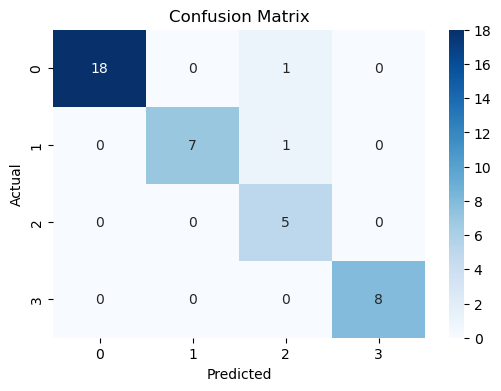

In [16]:
#Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
#Feature Importance
feat_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feat_importance = feat_importance.sort_values(by="Importance", ascending=False)
print("\n🔹 Feature Importance:\n", feat_importance)


🔹 Feature Importance:
           Feature  Importance
2  Spending Score    0.544523
1   Annual Income    0.421341
0             Age    0.034136


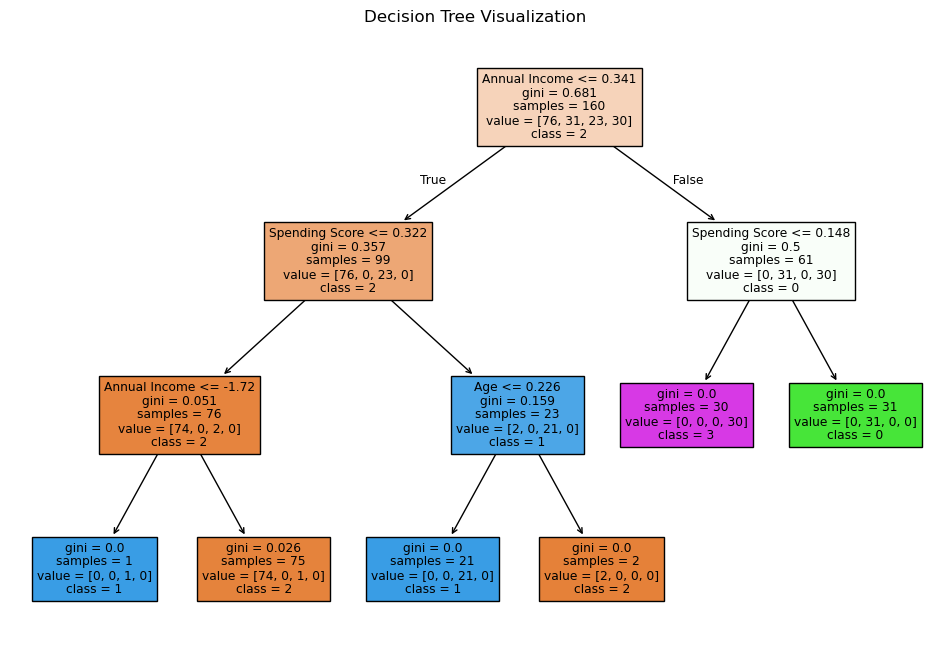

In [18]:
# Visualize Decision Tree
plt.figure(figsize=(12,8))
plot_tree(best_model, feature_names=X.columns, class_names=[str(i) for i in y.unique()], filled=True)
plt.title("Decision Tree Visualization")
plt.show()